# Project description

The aim of this project is to visualize the quantum and classical ground state of a small magnetic system with the help of jupyter notebook. The idea of this project comes from my research work, treating the magnetic skyrmions quantum mechanically in a frustrated system with the Hamiltonian 
\\[H=-J_1\sum_{<ij>}\mathbf{S}_i\cdot\mathbf{S}_j+J_2\sum_{\ll ij\gg}\mathbf{S}_i\cdot\mathbf{S}_j-K\sum_{<ij>}S_i^zS_j^z-B\sum_iS_i^z\\]
where $\mathbf{S}_i$ is the spin operator of the ith site, $S_i^z$ specifies the $z-$direction component, $J_1$ is the nearest-neighbour ferromagnetic Heisenberg coupling strength, $J_2$ is the next-nearest-neighbour antiferromagnetic coupling strength, $K$ is the easy-axis anisotropy and $B$ is the external field.

Finding the ground state of the given Hamiltonian with real system will take long computation time, thus in this project, system with small size (around 10 spin sites) is considered. After diagonalizing the Hamiltonian matrix with the `eigh` function from the `numpy.linalg` package, the expectation values of the spin operators $\langle S_i^\alpha\rangle$ is calculated with the ground state. Then the quantum spins can be visualized by plotting the spin expectation values in 3D. The classical ground state, on the other hand, can also be calculated with energy variation method or classical Monte Carlo. The comparison of quantum and classical systems can be used in the teaching of matrix quantum mechanics and electromagnetism.

In [1]:
import numpy as np

import time

In [2]:
from scipy.sparse.linalg import eigs, eigsh
from numpy.linalg import eig, eigh

In [3]:
def cS(m,alpha,N):
    'define the 1-spin operator S_m^alpha. The matrix representation is a 2**N-d square matrix.'
    if m-1 in range(N):
        sigma = np.empty([2,2,3], dtype=np.complex_)
        sigma[:,:,0] = np.array([[0,1],[1,0]]) * 0.5
        sigma[:,:,1] = np.array([[0,-1j],[1j,0]]) * 0.5
        sigma[:,:,2] = np.array([[1,0],[0,-1]]) * 0.5
        mat = np.empty([2,2,N], dtype=np.complex_)
        for i in range(N):
            mat[:,:,i] = np.eye(2)
        mat[:,:,m-1] = sigma[:,:,alpha-1]
        S = mat[:,:,0]
        for i in range(1,N):
            S = np.kron(S,mat[:,:,i])
    else:
        S = 0
    return S    

In [4]:
def cSS(m,alpha,n,beta,N):
    'define the 2-spin operator S_m^alpha S_n^beta. The matrix representation is a 2**N-d square matrix.'
    if (m-1 in range(N)) & (n-1 in range(N)):
        sigma = np.empty([2,2,3], dtype=np.complex_)
        sigma[:,:,0] = np.array([[0,1],[1,0]]) * 0.5
        sigma[:,:,1] = np.array([[0,-1j],[1j,0]]) * 0.5
        sigma[:,:,2] = np.array([[1,0],[0,-1]]) * 0.5
        mat = np.empty([2,2,N], dtype=np.complex_)
        for i in range(N):
            mat[:,:,i] = np.eye(2)
        if m == n:
            mat[:,:,m-1] = np.matmul(sigma[:,:,alpha-1],sigma[:,:,beta-1])
        else:
            mat[:,:,m-1] = sigma[:,:,alpha-1]
            mat[:,:,n-1] = sigma[:,:,beta-1]
        S = mat[:,:,0]
        for i in range(1,N):
            S = np.kron(S,mat[:,:,i])
    else:
        S = 0
    return S    

In [5]:
def Neighb_Label_rect(dx,dy,ipdX,ipdY):
    '''
    Define the label of the nearest neighbouring (NN) 
    and the next nearest neighbouring (NNN) sites on a rectangle lattice.
    dx * dy defines the number of sites. 
    ipdX ,ipdY defines if the x/y direction has periodic boundary condition.
    '''
    nLabel = np.zeros([8,dx*dy], dtype = int) # the first four rows give the NN label
                                              # in x+ x- y+ y- direction; xpyp xpym ypxm ymxm
    NN = np.array([[1,3],[1,4],[2,3],[2,4]])  # the way of finding NNN
    nLabel[0,0:dx*dy-dy] = np.linspace(1+dy,dx*dy,dx*dy-dy)
    nLabel[1,dy:dx*dy] = np.linspace(1,dx*dy-dy,dx*dy-dy)
    for i in range(1,dx*dy+1):
        if i % dy:
            nLabel[2,i-1] = i+1
        if (i % dy) != 1:
            nLabel[3,i-1] = i-1
    if ipdX:
        nLabel[0,dx*dy-dy:dx*dy] = np.linspace(1,dy,dy)
        nLabel[1,0:dy] = np.linspace(dx*dy-dy+1,dx*dy,dy)
    if ipdY:
        for i in range(1,dx*dy+1):
            if not(i % dy):
                nLabel[2,i-1] = i+1-dy
            if (i % dy) == 1:
                nLabel[3,i-1] = i-1+dy
    for i in range(1,dx*dy+1):
        for j in range(4):
            if nLabel[NN[j,0]-1,i-1]:
                nLabel[j+4,i-1]=nLabel[NN[j,1]-1,nLabel[NN[j,0]-1,i-1]-1]
    
    return nLabel

In [6]:
def Site_Coord_hex(nl):
    '''
    Define the coordinates of the sites on a hexgonal lattice with open boundary condition.
    nl in range(2,5) is the number of layers. N = nl * 6 +1 defines the number of sites. 
    The basis vectors are e1 = [0, 1], e2 = [sqrt 3 /2, 1/2]
    site 1 is put on the origin
    '''
    N = nl * 6 + 1
    nCoord = np.zeros([N,2])
    # center site nCoord[0,:]=ap.array([0,0])
    
    # first layer, distance from center = 1
    nCoord[1:7,:] = np.array([[i,j] for i in range(-1,2) for j in range(-1,2) if i-j])
    
    # second layer, distance from center = sqrt 3
    if nl > 1:
        nCoord[7:13,:] = np.array([[i,j] for i in [1,-1,2,-2] for j in [1,-1,2,-2] if i*j in [1,-2]])
    
    # third layer distance from center = 2
    if nl > 2:
        nCoord[13:19,:] = 2 * nCoord[1:7,:]
    
    return nCoord

In [7]:
def Neighb_Label_hex(nl):
    '''
    Define the label of the nearest neighbouring (NN) 
    and the next nearest neighbouring (NNN) sites on a hexgonal lattice with open boundary condition.
    nl in range(2,5) is the number of layers. nl * 6 +1 defines the number of sites. 
    '''
    N = 6*nl+1
    nLabel = np.zeros([12,N], dtype = int) # the first 6 rows give the NN label
                                           # the second 6 rows give the NNN label
    nCoord = Site_Coord_hex(nl)
    nn_vector = np.array([[1,0],[0,1],[-1,1]])
    nnn_vector = np.array([[1,1],[-1,2],[-2,1]])
    
    for i in range(N):
        for j in range(3):
            temp = nCoord[i,:] + nn_vector[j,:]                 # move from site i to its NN i'
            if np.equal(nCoord,temp).all(axis=1).any():         # check if i' is in the lattice 
                nLabel[j,i] = np.where((nCoord == temp).all(axis=1))[0][0] + 1
            temp = nCoord[i,:] - nn_vector[j,:]
            if np.equal(nCoord,temp).all(axis=1).any():
                nLabel[j+3,i] = np.where((nCoord == temp).all(axis=1))[0][0] + 1
            temp2 = nCoord[i,:] + nnn_vector[j,:]                 # move from site i to its NN i'
            if np.equal(nCoord,temp2).all(axis=1).any():         # check if i' is in the lattice 
                nLabel[j+6,i] = np.where((nCoord == temp2).all(axis=1))[0][0] + 1
            temp2 = nCoord[i,:] - nnn_vector[j,:]
            if np.equal(nCoord,temp2).all(axis=1).any():
                nLabel[j+9,i] = np.where((nCoord == temp2).all(axis=1))[0][0] + 1
    return nLabel

### Diagonalization

The diagonalization of the Hamiltonian matrix can be done with 
1. [scipy.sparse.linalg.eigsh](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.eigsh.html)
2. [numpy.linalg.eigh](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html#numpy.linalg.eigh)

In [8]:
time_start = time.process_time()

lat = 'hex'
nx = 3
ny = 3    
nl = 1

if lat == 'rect':
    Ns = nx * ny
    n_nei = 4    # number of NN on the center site
    nb = Neighb_Label_rect(nx,ny,0,0)

if lat == 'hex':
    Ns = 6 * nl + 1
    n_nei = 6
    nb = Neighb_Label_hex(nl)

J  = 1.
J2 = -0.8
h  = 0.1
ani = 0.05
Hmat = np.zeros([2**Ns,2**Ns], dtype=np.complex64)

for i in range(1,Ns+1):
    for j in range(n_nei):
        for alpha in range(1,4):
            if J != 0:                                            # NN
                Hmat -= cSS(i,alpha,nb[j,i-1],alpha,Ns) * J
            if J2 != 0:                                           # NNN
                Hmat -= cSS(i,alpha,nb[j+n_nei,i-1],alpha,Ns) * J2
        if ani != 0:                                              # anisotropy along z-direction
            Hmat -= cSS(i,3,nb[j,i-1],3,Ns) * ani
    if h != 0:                                                    # external field
        Hmat -= cS(i,3,Ns) * h    

#valsh, vecsh = eigsh(np.matrix(Hmat),k = 2, which = 'SA')          # diagonalization with Lanczos
vals, vecs = eigh(Hmat)

print("Time used: %.2f" %(time.process_time()-time_start))


Time used: 1.14


In [9]:
gs = vecs[:,0]
spEx = np.empty([3,Ns])
for i in range(1,Ns+1):
    for alpha in range(1,4):
        spEx[alpha-1,i-1] = np.matmul(gs.T,np.dot(cS(i,alpha,Ns),gs)).real
        if abs(spEx[alpha-1,i-1]) < 1e-6:
            spEx[alpha-1,i-1]=0

In [10]:
spEx

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.49997981, 0.26124151, 0.11009819, 0.12867043, 0.12867043,
        0.11009818, 0.26124151]])

In [183]:
valsh, vecsh = eigsh(np.matrix(Hmat),k = 2, which = 'SA')

In [184]:
vals, vecs = eigh(np.matrix(Hmat))

In [185]:
print(valsh[0])
print(vals[0])

-4.698663
-4.6986413


# Classical spins

In [11]:
def init_spin_rect(dx,dy):
    '''
    Initialize the classical spins on a dx * dy rectangle lattice with classical spin |S| = 1.
    The orientations of the spins are randomly distributed.
    '''
    N = dx * dy
    spin0 = np.random.rand(3,N) * 2 -1
    norm = (spin0 * spin0).sum(0)**0.5
    spin0 /= norm
    return spin0

In [195]:
s0=init_spin_rect(3,2)

In [197]:
s0.shape[1]

6

In [12]:
def make_en(spin,neib,cp):
    '''calculate the energy of a given classical configuration (defined with spins and neighbouring labels)
    under coupling interactions (J, J2, h, ani)'''
    J = cp[0]
    J2 = cp[1]
    h = cp[2]
    ani = cp[3]
    en = 0
    for i in range(spin.shape[1]):
        for j in range(4):
            for alpha in range(3):
                if J:
                    en -= J * spin[alpha,i] * spin[alpha,neib[j,i]-1]
                if J2:
                    en -= J2 * spin[alpha,i] * spin[alpha+4,neib[j,i]-1]
            if ani:
                en -= ani * spin[2,i] * spin[2,neib[j,i]-1]
        if h:
            en -= h * spin[2,i]
    return en

## Visualization

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [14]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [16]:
u,v,w = init_spin_rect(3,3)

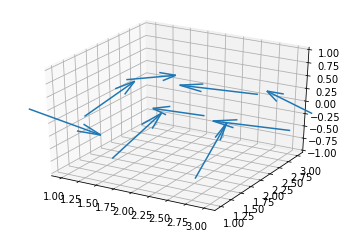

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


X = np.array([1,2,3,1,2,3,1,2,3])
Y = np.array([1,1,1,2,2,2,3,3,3])

ax.quiver(X, Y, np.zeros([1,9]),u, v, w,pivot='middle')
ax.set_zlim(-1,1)

plt.show()

<IPython.core.display.Javascript object>


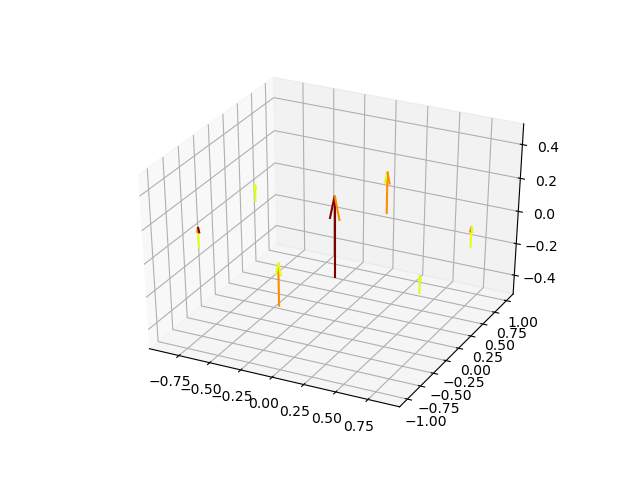

In [250]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


X = Site_Coord_hex(1)[:,1]*np.sqrt(3)/2
Y = Site_Coord_hex(1)[:,0]+Site_Coord_hex(1)[:,1]/2
Z = np.zeros([1,7])
norm = Normalize()
norm.autoscale([-0.5,0.5])
colormap=cm.jet
ax.quiver(X, Y, Z, spEx[0,:], spEx[1,:], spEx[2,:],pivot='middle',color=colormap(norm(spEx[2,:])))
ax.set_zlim(-0.5, 0.5)
plt.show()